# **Hugging Face Computer Vision Course: Unit 5-8**

## **Unit 5 - Generative Models**

#### **Section 1: Variational Autoencoders (VAEs)**



**Membahas apa**: Bagian ini membahas bagaimana Variational Autoencoders (VAEs) bekerja menggunakan encoder dan decoder untuk memetakan data ke ruang laten dan merekonstruksi data dari ruang laten tersebut. Fokus utama adalah mempelajari representasi data secara ringkas.

1. **Encoder dan Decoder**:
   - **Encoder** mengubah data input berdimensi tinggi menjadi representasi laten (mean dan log-variance) yang menangkap fitur utama dari input tersebut.
   - **Decoder** merekonstruksi kembali data asli dari representasi laten, pada dasarnya membalikkan proses encoding.
   - Proses ini memastikan model mempelajari representasi data yang ringkas sekaligus mempertahankan struktur esensialnya.

2. **Reparameterization Trick**:
   - Karena pengambilan sampel dari distribusi tidak dapat didiferensiasikan, trik reparameterisasi digunakan. Trik ini melibatkan dekomposisi representasi laten menjadi parameter deterministik (mean dan variance) dan elemen noise acak, memungkinkan gradien dapat dihitung selama backpropagation.

3. **Fungsi Loss**:
   - **Reconstruction Loss** (BCELoss) memastikan data yang direkonstruksi sedekat mungkin dengan data input asli.
   - **KL Divergence** meregulasi ruang laten, memastikan distribusi vektor laten mendekati distribusi normal standar. Ini membantu menghasilkan sampel yang halus saat membuat data baru.

4. **Pelatihan Model**:
   - Encoder dan decoder dilatih secara bersamaan. Model meminimalkan total loss (reconstruction loss + KL divergence) menggunakan optimizer berbasis gradien seperti Adam.

5. **Aplikasi**:
   - VAE digunakan dalam pembuatan gambar, deteksi anomali, dan pengurangan dimensi data.

In [2]:
import torch
import torch.nn as nn

# Encoder pada VAE bertugas untuk memetakan data input ke representasi laten (mean dan log-variance).
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  # Lapisan pertama memetakan dimensi input ke 128 dimensi
            nn.ReLU(),  # Fungsi aktivasi untuk menambahkan non-linearitas
            nn.Linear(128, latent_dim * 2)  # Output adalah mean dan log-variance
        )

    def forward(self, x):
        params = self.fc(x)  # Proses input melalui jaringan fully connected
        mean, log_var = params.chunk(2, dim=-1)  # Membagi output menjadi mean dan log-variance
        return mean, log_var  # Mengembalikan mean dan log-variance

# Decoder pada VAE bertugas untuk merekonstruksi data dari representasi laten.
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Lapisan pertama memetakan ruang laten ke 128 dimensi
            nn.ReLU(),  # Fungsi aktivasi untuk non-linearitas
            nn.Linear(128, output_dim),  # Lapisan terakhir menghasilkan output dalam dimensi asli
            nn.Sigmoid()  # Aktivasi sigmoid untuk menormalkan output antara 0 dan 1
        )

    def forward(self, z):
        return self.fc(z)  # Menghasilkan rekonstruksi data dari vektor laten

# Model VAE menggabungkan encoder dan decoder serta menerapkan reparameterisasi.
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)  # Membuat instance encoder
        self.decoder = Decoder(latent_dim, input_dim)  # Membuat instance decoder

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)  # Menghitung standar deviasi dari log-variance
        eps = torch.randn_like(std)  # Mengambil sampel noise acak
        return mean + eps * std  # Trik reparameterisasi untuk membuat ruang laten dapat dibedakan

    def forward(self, x):
        mean, log_var = self.encoder(x)  # Encode data input ke mean dan log-variance
        z = self.reparameterize(mean, log_var)  # Menghasilkan vektor laten menggunakan reparameterisasi
        reconstructed = self.decoder(z)  # Decode vektor laten untuk menghasilkan data rekonstruksi
        return reconstructed, mean, log_var  # Mengembalikan data rekonstruksi dan parameter laten

**Contoh Codingan Lengkap**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 450kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.80MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 152.0324
Epoch 2, Loss: 124.8851
Epoch 3, Loss: 120.8496
Epoch 4, Loss: 118.7289
Epoch 5, Loss: 117.3977
Epoch 6, Loss: 116.4905
Epoch 7, Loss: 115.7821
Epoch 8, Loss: 115.2168
Epoch 9, Loss: 114.7828
Epoch 10, Loss: 114.3484
Epoch 11, Loss: 114.0305
Epoch 12, Loss: 113.6958
Epoch 13, Loss: 113.4112
Epoch 14, Loss: 113.2129
Epoch 15, Loss: 112.9709
Epoch 16, Loss: 112.7426
Epoch 17, Loss: 112.5682
Epoch 18, Loss: 112.4365
Epoch 19, Loss: 112.2759
Epoch 20, Loss: 112.1286


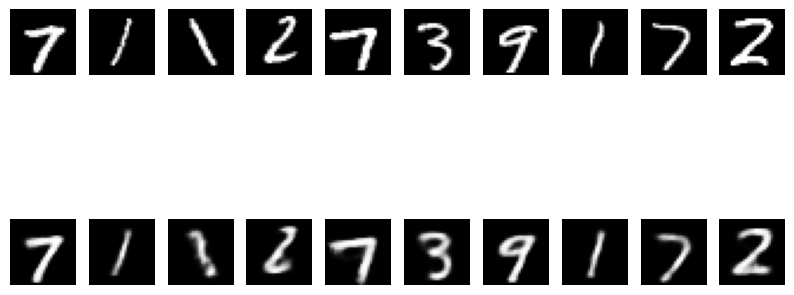

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Encoder pada VAE bertugas untuk memetakan data input ke representasi laten (mean dan log-variance).
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Output adalah mean dan log-variance
        )

    def forward(self, x):
        params = self.fc(x)
        mean, log_var = params.chunk(2, dim=-1)
        return mean, log_var

# Decoder pada VAE bertugas untuk merekonstruksi data dari representasi laten.
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()  # Aktivasi sigmoid untuk menormalkan output antara 0 dan 1
        )

    def forward(self, z):
        return self.fc(z)

# Model VAE menggabungkan encoder dan decoder serta menerapkan reparameterisasi.
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Fungsi loss untuk VAE
def loss_function(reconstructed, original, mean, log_var):
    recon_loss = nn.BCELoss(reduction='sum')(reconstructed, original)
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_div

# Data MNIST untuk eksperimen
input_dim = 28 * 28  # Dimensi data (gambar 28x28 diratakan menjadi vektor)
latent_dim = 10  # Dimensi laten

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Meratakan gambar menjadi vektor
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True, num_workers= 12)

# Inisialisasi model, optimizer, dan hyperparameter
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Pelatihan model
num_epochs = 20
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch, _ in train_loader:
        optimizer.zero_grad()
        reconstructed, mean, log_var = vae(batch)
        loss = loss_function(reconstructed, batch, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# Evaluasi dan visualisasi hasil
vae.eval()
with torch.no_grad():
    test_data = next(iter(train_loader))[0][:10]  # Mengambil beberapa sampel data untuk evaluasi
    reconstructed, _, _ = vae(test_data)

# Visualisasi data asli dan rekonstruksi
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_data[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
plt.show()


Pada output gambar:

- **Baris pertama** menunjukkan sampel data asli dari dataset MNIST, yang terdiri dari gambar digit 0–9.
- **Baris kedua** menunjukkan hasil rekonstruksi dari data asli menggunakan model Variational Autoencoder (VAE).

Penjelasan Singkat:
1. **Kualitas Rekonstruksi**: VAE berhasil merekonstruksi digit dengan tingkat akurasi visual yang cukup baik. Bentuk dan struktur digit umumnya dipertahankan, meskipun terdapat sedikit distorsi.
2. **Distorsi**: Distorsi kecil terjadi karena proses sampling dan pembelajaran VAE, terutama karena ruang laten dengan dimensi yang terbatas (10) memampatkan informasi.
3. **Hasil yang diharapkan**: VAE umumnya menghasilkan rekonstruksi yang mirip tetapi tidak identik dengan data asli, karena tujuan utama adalah mempelajari distribusi data, bukan sekadar menyalin data.




#### **Section 2: Generative Adversarial Networks (GANs)**


**Membahas apa**: Bagian ini menjelaskan bagaimana GAN bekerja dengan menggunakan dua jaringan saraf: Generator dan Discriminator. Fokusnya adalah menghasilkan data realistis melalui pelatihan adversarial antara Generator dan Discriminator.

1. **Arsitektur**:
   - GAN terdiri dari dua jaringan saraf:
     - **Generator** menghasilkan data palsu dari noise acak.
     - **Discriminator** mengevaluasi apakah data input asli atau hasil dari Generator.

2. **Dinamika Pelatihan**:
   - GAN dilatih secara adversarial:
     - Generator berusaha membuat data yang dapat menipu Discriminator agar menganggapnya asli.
     - Discriminator berusaha meningkatkan kemampuannya membedakan data asli dan palsu.

3. **Fungsi Loss**:
   - **Discriminator Loss**: Mengukur seberapa baik Discriminator mengklasifikasikan data asli dan palsu.
   - **Generator Loss**: Mengukur seberapa baik Generator dapat menipu Discriminator.

4. **Tantangan**:
   - **Mode Collapse**: Generator hanya menghasilkan variasi output yang terbatas.
   - **Stabilitas Pelatihan**: GAN memerlukan penyetelan hyperparameter yang cermat untuk stabilitas pelatihan.

5. **Aplikasi**:
   - GAN digunakan secara luas untuk pembuatan gambar, transfer gaya, augmentasi data, dan peningkatan resolusi gambar.


In [ ]:
# Generator bertugas menghasilkan data palsu yang menyerupai data asli.
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 128),  # Lapisan pertama memetakan noise ke 128 dimensi
            nn.ReLU(),  # Fungsi aktivasi untuk non-linearitas
            nn.Linear(128, 256),  # Lapisan kedua memperbesar dimensi ke 256
            nn.ReLU(),  # Fungsi aktivasi
            nn.Linear(256, output_dim),  # Lapisan terakhir memetakan ke dimensi output
            nn.Tanh()  # Aktivasi Tanh untuk menghasilkan output dalam rentang [-1, 1]
        )

    def forward(self, x):
        return self.fc(x)  # Menghasilkan data palsu dari noise

# Discriminator bertugas membedakan data asli dan data palsu yang dihasilkan Generator.
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),  # Lapisan pertama memetakan data ke 256 dimensi
            nn.LeakyReLU(0.2),  # Fungsi aktivasi dengan slope negatif
            nn.Linear(256, 128),  # Lapisan kedua memperkecil dimensi ke 128
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(128, 1),  # Lapisan terakhir menghasilkan satu output (real/fake)
            nn.Sigmoid()  # Aktivasi sigmoid untuk probabilitas
        )

    def forward(self, x):
        return self.fc(x)  # Mengembalikan probabilitas data asli atau palsu

**Contoh Codingan Lengkap**

Epoch [1/50], d_loss: 0.1725, g_loss: 3.8858
Epoch [2/50], d_loss: 0.2781, g_loss: 3.9946
Epoch [3/50], d_loss: 0.5579, g_loss: 1.5843
Epoch [4/50], d_loss: 0.1035, g_loss: 4.7647
Epoch [5/50], d_loss: 0.2221, g_loss: 4.2890
Epoch [6/50], d_loss: 0.1063, g_loss: 4.4981
Epoch [7/50], d_loss: 0.1389, g_loss: 6.3038
Epoch [8/50], d_loss: 0.1708, g_loss: 4.7756
Epoch [9/50], d_loss: 0.2644, g_loss: 4.9354
Epoch [10/50], d_loss: 0.1914, g_loss: 4.2283
Epoch [11/50], d_loss: 0.2488, g_loss: 2.8406
Epoch [12/50], d_loss: 0.3069, g_loss: 5.0835
Epoch [13/50], d_loss: 0.2095, g_loss: 4.2630
Epoch [14/50], d_loss: 0.3956, g_loss: 5.6601
Epoch [15/50], d_loss: 0.3103, g_loss: 5.5744
Epoch [16/50], d_loss: 0.2061, g_loss: 3.8620
Epoch [17/50], d_loss: 0.2015, g_loss: 4.2204
Epoch [18/50], d_loss: 0.1531, g_loss: 6.0019
Epoch [19/50], d_loss: 0.1464, g_loss: 5.4681
Epoch [20/50], d_loss: 0.3989, g_loss: 4.3691
Epoch [21/50], d_loss: 0.4019, g_loss: 3.7768
Epoch [22/50], d_loss: 0.3403, g_loss: 2.31

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6d9d5bfe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6d9d5bfe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [44/50], d_loss: 0.5188, g_loss: 2.3422
Epoch [45/50], d_loss: 0.6010, g_loss: 1.8664
Epoch [46/50], d_loss: 0.9668, g_loss: 1.8281
Epoch [47/50], d_loss: 0.7262, g_loss: 2.0817
Epoch [48/50], d_loss: 0.9144, g_loss: 2.6169
Epoch [49/50], d_loss: 0.4434, g_loss: 2.9604
Epoch [50/50], d_loss: 0.5090, g_loss: 3.0490


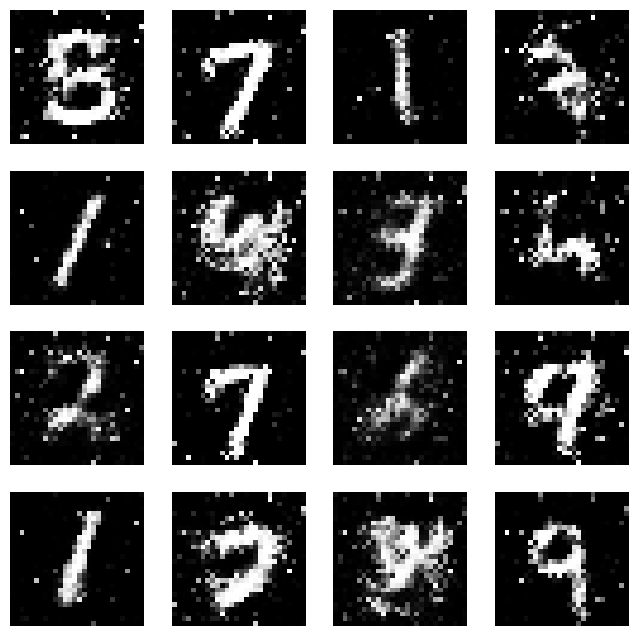

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Generator bertugas menghasilkan data palsu yang menyerupai data asli.
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 128),  # Lapisan pertama memetakan noise ke 128 dimensi
            nn.ReLU(),  # Fungsi aktivasi untuk non-linearitas
            nn.Linear(128, 256),  # Lapisan kedua memperbesar dimensi ke 256
            nn.ReLU(),  # Fungsi aktivasi
            nn.Linear(256, output_dim),  # Lapisan terakhir memetakan ke dimensi output
            nn.Tanh()  # Aktivasi Tanh untuk menghasilkan output dalam rentang [-1, 1]
        )

    def forward(self, x):
        return self.fc(x)  # Menghasilkan data palsu dari noise

# Discriminator bertugas membedakan data asli dan data palsu yang dihasilkan Generator.
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),  # Lapisan pertama memetakan data ke 256 dimensi
            nn.LeakyReLU(0.2),  # Fungsi aktivasi dengan slope negatif
            nn.Linear(256, 128),  # Lapisan kedua memperkecil dimensi ke 128
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(128, 1),  # Lapisan terakhir menghasilkan satu output (real/fake)
            nn.Sigmoid()  # Aktivasi sigmoid untuk probabilitas
        )

    def forward(self, x):
        return self.fc(x)  # Mengembalikan probabilitas data asli atau palsu

# Data MNIST untuk eksperimen
input_dim = 28 * 28  # Dimensi data (gambar 28x28 diratakan menjadi vektor)
noise_dim = 100  # Dimensi noise sebagai input untuk Generator

transform = transforms.Compose([
    transforms.ToTensor(),  # Konversi gambar menjadi tensor
    transforms.Normalize([0.5], [0.5]),  # Normalisasi ke rentang [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Meratakan gambar menjadi vektor
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers =12)

# Inisialisasi model, optimizer, dan loss function
generator = Generator(noise_dim, input_dim)
discriminator = Discriminator(input_dim)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Pelatihan model
num_epochs = 50
for epoch in range(num_epochs):
    for real_data, _ in train_loader:
        # Pelatihan Discriminator
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Data asli
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        # Data palsu
        noise = torch.randn(batch_size, noise_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total loss dan optimasi
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Pelatihan Generator
        noise = torch.randn(batch_size, noise_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Visualisasi hasil
noise = torch.randn(16, noise_dim)
with torch.no_grad():
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2  # Denormalisasi ke rentang [0, 1]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i][0].numpy(), cmap='gray')
    plt.axis('off')
plt.show()




1. **Barisan Gambar**: Gambar-gambar pada grid merupakan hasil **sintetik** yang dihasilkan oleh Generator pada GAN setelah pelatihan.
   
2. **Kualitas Gambar**:
   - Gambar terlihat **cukup menyerupai digit MNIST**, tetapi terdapat beberapa **distorsi** atau noise, terutama di bagian tepi angka.
   - Hal ini menunjukkan bahwa model Generator masih memiliki ruang untuk perbaikan dalam menghasilkan data yang lebih realistis.

3. **Tahapan Pelatihan**:
   - Pada epoch awal, generator menghasilkan gambar yang kurang jelas karena belum memahami distribusi data asli.
   - Seiring waktu, gambar mulai menyerupai digit MNIST dengan bentuk yang lebih jelas.

4. **Distorsi atau Noise**:
   - Noise yang masih terlihat mungkin disebabkan oleh **keseimbangan antara Generator dan Discriminator**. Jika salah satu lebih dominan, hasil gambar menjadi kurang realistis.
   - Dimensi ruang noise (`noise_dim`) dan parameter pelatihan (seperti learning rate) juga memengaruhi hasil.



#### **Section 3: StyleGAN Variants**


**Membahas apa**: Bagian ini membahas inovasi StyleGAN, yang menggunakan pendekatan berbasis gaya untuk menghasilkan gambar berkualitas tinggi dengan kontrol atribut visual.

1. **Inovasi Utama**:
   - StyleGAN memperkenalkan **style-based generation**, di mana variabel laten memengaruhi beberapa lapisan dalam jaringan.
   - Hal ini memungkinkan kontrol yang lebih besar atas atribut gambar seperti pose, warna, dan tekstur.

2. **Arsitektur**:
   - StyleGAN menggunakan jaringan pemetaan (mapping network) untuk mengubah vektor laten menjadi representasi intermediate yang disebut "styles."
   - Input noise ditambahkan pada lapisan tertentu untuk memperkenalkan detail yang halus.

3. **Aplikasi**:
   - StyleGAN digunakan untuk pembuatan wajah berkualitas tinggi, rendering artistik, dan sintesis gambar dengan atribut terkontrol.

4. **Keuntungan**:
   - Menghasilkan gambar yang sangat realistis dengan kontrol lebih rinci terhadap atribut tertentu.



In [ ]:
# StyleGAN Generator memungkinkan kontrol atribut visual pada data yang dihasilkan.
class StyleGANGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(StyleGANGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),  # Lapisan pertama memetakan ruang laten ke 512 dimensi
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(512, 1024),  # Lapisan kedua memperbesar dimensi ke 1024
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(1024, 28 * 28),  # Lapisan terakhir memetakan ke dimensi gambar (28x28)
            nn.Tanh()  # Aktivasi Tanh untuk menormalkan output
        )

    def forward(self, z):
        return self.fc(z).view(-1, 1, 28, 28)  # Mengubah output menjadi format gambar

**Contoh Codingan Lengkap**

Epoch [1/20], d_loss: 0.0071, g_loss: 6.0400
Epoch [2/20], d_loss: 0.0197, g_loss: 11.9842
Epoch [3/20], d_loss: 0.0028, g_loss: 7.4819
Epoch [4/20], d_loss: 0.0004, g_loss: 10.7393
Epoch [5/20], d_loss: 0.0000, g_loss: 10.9999
Epoch [6/20], d_loss: 0.0000, g_loss: 13.7088
Epoch [7/20], d_loss: 0.0000, g_loss: 14.6210
Epoch [8/20], d_loss: 0.0000, g_loss: 14.7773
Epoch [9/20], d_loss: 0.0000, g_loss: 15.3790
Epoch [10/20], d_loss: 0.0000, g_loss: 15.2649
Epoch [11/20], d_loss: 0.0110, g_loss: 11.2052
Epoch [12/20], d_loss: 0.0000, g_loss: 10.2638
Epoch [13/20], d_loss: 0.0000, g_loss: 13.5623
Epoch [14/20], d_loss: 0.0000, g_loss: 12.9858
Epoch [15/20], d_loss: 0.0000, g_loss: 14.6845
Epoch [16/20], d_loss: 0.0000, g_loss: 11.0588
Epoch [17/20], d_loss: 0.0011, g_loss: 63.2479
Epoch [18/20], d_loss: 0.0001, g_loss: 15.5488
Epoch [19/20], d_loss: 0.0034, g_loss: 41.4623
Epoch [20/20], d_loss: 0.0000, g_loss: 12.6894


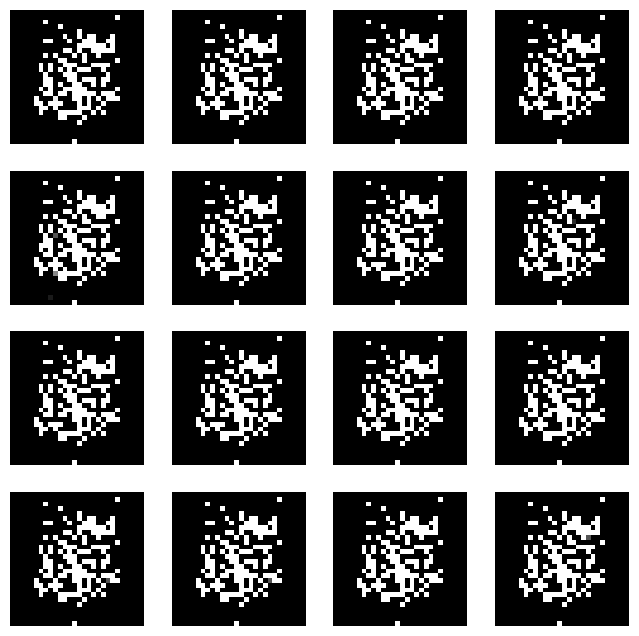

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# StyleGAN Generator memungkinkan kontrol atribut visual pada data yang dihasilkan.
class StyleGANGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(StyleGANGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),  # Lapisan pertama memetakan ruang laten ke 512 dimensi
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(512, 1024),  # Lapisan kedua memperbesar dimensi ke 1024
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(1024, 28 * 28),  # Lapisan terakhir memetakan ke dimensi gambar (28x28)
            nn.Tanh()  # Aktivasi Tanh untuk menormalkan output
        )

    def forward(self, z):
        return self.fc(z).view(-1, 28 * 28)  # Mengubah output menjadi vektor gambar

# Discriminator bertugas membedakan data asli dan data palsu yang dihasilkan Generator.
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),  # Lapisan pertama memetakan data ke 256 dimensi
            nn.LeakyReLU(0.2),  # Fungsi aktivasi dengan slope negatif
            nn.Linear(256, 128),  # Lapisan kedua memperkecil dimensi ke 128
            nn.LeakyReLU(0.2),  # Fungsi aktivasi
            nn.Linear(128, 1),  # Lapisan terakhir menghasilkan satu output (real/fake)
            nn.Sigmoid()  # Aktivasi sigmoid untuk probabilitas
        )

    def forward(self, x):
        return self.fc(x)  # Mengembalikan probabilitas data asli atau palsu

# Data MNIST untuk eksperimen
input_dim = 28 * 28  # Dimensi data (gambar 28x28 diratakan menjadi vektor)
latent_dim = 100  # Dimensi laten untuk StyleGAN

transform = transforms.Compose([
    transforms.ToTensor(),  # Konversi gambar menjadi tensor
    transforms.Normalize([0.5], [0.5]),  # Normalisasi ke rentang [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Meratakan gambar menjadi vektor
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=12)

# Inisialisasi model, optimizer, dan loss function
generator = StyleGANGenerator(latent_dim)
discriminator = Discriminator(input_dim)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Pelatihan model
num_epochs = 20
for epoch in range(num_epochs):
    for real_data, _ in train_loader:
        # Pelatihan Discriminator
        batch_size = real_data.size(0)
        real_data = real_data.view(batch_size, -1)  # Meratakan gambar
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Data asli
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        # Data palsu
        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total loss dan optimasi
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Pelatihan Generator
        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Visualisasi hasil
noise = torch.randn(16, latent_dim)
with torch.no_grad():
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2  # Denormalisasi ke rentang [0, 1]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i][0].numpy(), cmap='gray')
    plt.axis('off')
plt.show()


Analisis Hasil Output

1. **Visualisasi Gambar**:
   - Gambar yang dihasilkan memiliki pola acak dengan sedikit struktur.
   - Namun, gambar tidak menyerupai digit MNIST, menunjukkan bahwa **Generator** gagal mempelajari distribusi data asli dengan baik.

2. **Nilai `d_loss` dan `g_loss`**:
   - `d_loss` mendekati nol sangat cepat (misalnya, `d_loss: 0.0000` dari Epoch 5 ke atas), menunjukkan bahwa **Discriminator** menjadi terlalu dominan.
   - `g_loss` sangat tinggi (contoh, `g_loss: 15.5488`), yang mencerminkan Generator kesulitan menghasilkan data yang meyakinkan untuk mengecoh Discriminator.

3. **Masalah Utama**:
   - Ketidakseimbangan antara Generator dan Discriminator, di mana Discriminator belajar terlalu cepat dibandingkan Generator.
   - **Mode collapse**: Generator menghasilkan pola acak yang serupa tanpa variasi atau struktur yang menyerupai data asli.


#### **Section 4: CycleGAN Introduction**




**Membahas apa**: Bagian ini membahas bagaimana CycleGAN memungkinkan translasi gambar-ke-gambar tanpa dataset berpasangan, seperti mengubah foto menjadi lukisan.

1. **Konsep Utama**:
   - CycleGAN dirancang untuk **unpaired image-to-image translation**. Misalnya, dapat mengubah gambar dari satu domain (misalnya foto) ke domain lain (misalnya lukisan) tanpa memerlukan pasangan data.

2. **Arsitektur**:
   - CycleGAN menggunakan dua generator (untuk masing-masing arah translasi) dan dua discriminator untuk mengevaluasi gambar yang dihasilkan.
   - **Cycle Consistency Loss** memastikan bahwa penerjemahan gambar kembali ke domain aslinya menghasilkan hasil yang mendekati input awal.

3. **Aplikasi**:
   - CycleGAN digunakan untuk transfer gaya (misalnya foto ke lukisan Van Gogh), adaptasi domain, dan augmentasi data.

4. **Keuntungan**:
   - Menghilangkan kebutuhan akan dataset berpasangan, yang sering kali sulit diperoleh.

In [ ]:
# ResNetBlock adalah bagian utama dari CycleGAN untuk mempelajari fitur-fitur kompleks dalam gambar.
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1),  # Lapisan konvolusi pertama
            nn.ReLU(True),  # Fungsi aktivasi
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1)  # Lapisan konvolusi kedua
        )

    def forward(self, x):
        return x + self.block(x)  # Menambahkan input asli dengan hasil konvolusi (skip connection)

#### **Section 5: Diffusion Models**


**Membahas apa**: Bagian ini menjelaskan model difusi yang bekerja dengan menambahkan noise secara bertahap pada data asli (proses forward) dan menghapus noise untuk merekonstruksi data (proses reverse).

1. **Proses Forward**:
   - Noise secara bertahap ditambahkan ke data langkah demi langkah hingga data menjadi tidak dapat dikenali sepenuhnya. Proses ini dimodelkan sebagai rantai Markov.

2. **Proses Reverse**:
   - Dimulai dari data yang penuh noise, proses reverse secara bertahap menghapus noise, merekonstruksi data asli.

3. **Pelatihan**:
   - Model dilatih untuk memprediksi noise yang ditambahkan pada setiap langkah, memungkinkan proses rekonstruksi.

4. **Aplikasi**:
   - Model Diffusion digunakan dalam sintesis gambar, pembuatan suara, dan simulasi ilmiah.

5. **Keuntungan**:
   - Menghasilkan output berkualitas tinggi dan beragam dengan dasar teoretis yang kuat.


In [ ]:
# Proses difusi menambahkan noise ke data secara bertahap.
def diffusion_process(data, num_steps=10, noise_factor=0.1):
    for step in range(num_steps):
        noise = torch.randn_like(data) * noise_factor  # Menambahkan noise Gaussian
        data = data + noise  # Mengubah data dengan noise
    return data

# Proses reverse difusi menghapus noise secara bertahap untuk merekonstruksi data asli.
def reverse_diffusion(noisy_data, num_steps=10, noise_factor=0.1):
    for step in range(num_steps):
        noise = torch.randn_like(noisy_data) * noise_factor  # Noise untuk dihapus
        noisy_data = noisy_data - noise  # Mengurangi noise dari data
    return noisy_data

#### **Section 6: Stable Diffusion**




**Membahas apa**: Bagian ini menjelaskan bagaimana Stable Diffusion bekerja di ruang laten untuk menghasilkan gambar resolusi tinggi dengan efisiensi komputasi yang lebih baik.

1. **Operasi Ruang Laten**:
   - Model Stable Diffusion bekerja dalam ruang laten yang terkompresi, di mana biaya komputasi lebih rendah dibandingkan operasi pada ruang piksel.

2. **Efisiensi**:
   - Penggunaan ruang laten memungkinkan pembuatan gambar resolusi tinggi sambil menjaga efisiensi komputasi.

3. **Aplikasi**:
   - Stable Diffusion digunakan untuk menghasilkan gambar fotorealistik, membuat karya seni, dan *inpainting* (mengisi bagian gambar yang hilang).

4. **Keuntungan**:
   - Lebih cepat dan dapat diskalakan dibandingkan model diffusion tradisional, menjadikannya cocok untuk aplikasi skala besar.

In [ ]:
# Model Stable Diffusion bekerja di ruang laten untuk meningkatkan efisiensi.
class LatentDiffusionModel(nn.Module):
    def __init__(self, latent_dim):
        super(LatentDiffusionModel, self).__init__()
        self.encoder = nn.Linear(latent_dim, 128)  # Encoder untuk memetakan data ke ruang laten
        self.decoder = nn.Linear(128, latent_dim)  # Decoder untuk merekonstruksi data dari ruang laten

    def forward(self, x):
        latent = self.encoder(x)  # Encode data ke ruang laten
        reconstruction = self.decoder(latent)  # Decode data dari ruang laten
        return reconstruction  # Menghasilkan data rekonstruksi

#### **Section 7: Control over Diffusion Models**



**Membahas apa**: Bagian ini menjelaskan bagaimana proses difusi dapat dikondisikan pada atribut tertentu, seperti deskripsi teks atau label kelas, untuk menghasilkan output yang spesifik.

1. **Kondisi pada Diffusion**:
   - Proses diffusion dapat diarahkan menggunakan input tambahan (misalnya deskripsi teks, label kelas). Ini memastikan output yang dihasilkan sesuai dengan atribut yang diinginkan.

2. **Aplikasi**:
   - Pembuatan gambar berdasarkan teks, sintesis gambar bersyarat kelas, dan pengeditan gambar berdasarkan fitur tertentu.

3. **Keuntungan**:
   - Memberikan kontrol yang tepat kepada pengguna atas proses pembuatan, memungkinkan output yang disesuaikan.


In [ ]:
# Proses difusi yang dikondisikan pada atribut tertentu.
def condition_diffusion(data, condition, num_steps=10):
    for step in range(num_steps):
        noise = torch.randn_like(data) * 0.1  # Menambahkan noise Gaussian
        data = data + noise * condition  # Menyesuaikan noise dengan kondisi
    return data  # Mengembalikan data yang dikondisikan

#### **Section 8: Privacy, Bias, and Societal Concerns**


**Membahas apa**: Bagian ini membahas pentingnya memastikan privasi, mengurangi bias, dan menangani dampak sosial dari model generatif, termasuk penggunaan yang etis dan bertanggung jawab.

1. **Privasi**:
   - Teknik seperti menghapus fitur yang dapat diidentifikasi (misalnya wajah) dan menerapkan blur digunakan untuk melindungi privasi individu dalam data yang dihasilkan.

2. **Mitigasi Bias**:
   - Memastikan dataset pelatihan seimbang untuk menghindari bias dalam output.

3. **Pertimbangan Etis**:
   - Menyoroti pentingnya penggunaan model generatif secara bertanggung jawab untuk mencegah penyalahgunaan, seperti pembuatan deepfake


In [ ]:
# Fungsi untuk menganonimkan gambar dengan mengaburkan fitur identitas.
def anonymize_image(image_data):
    blurred_data = nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2)(image_data)  # Mengaburkan data
    return blurred_data  # Mengembalikan data yang telah dianonimkan


## **Unit 6 - Basic CV Tasks**



**Membahas apa**: Bagian ini memberikan pengenalan tentang tugas-tugas dasar dalam Computer Vision, termasuk deteksi objek dan segmentasi gambar, serta penggunaannya dalam berbagai aplikasi seperti pengenalan wajah, mobil otonom, dan analisis medis.

#### **Section 1: Object Detection**


**Membahas apa**: Bagian ini menjelaskan deteksi objek, yaitu tugas untuk mengenali dan menentukan lokasi objek dalam gambar. Deteksi objek digunakan dalam berbagai aplikasi, seperti:
- **Keamanan dan Pengawasan**: Memantau aktivitas dalam video real-time untuk mendeteksi objek atau perilaku mencurigakan.
- **Kendaraan Otonom**: Mengenali pejalan kaki, kendaraan, rambu lalu lintas, dan elemen jalan lainnya.
- **Aplikasi Retail**: Menghitung inventaris atau memantau perilaku pelanggan di toko.


Gambar berhasil diunduh ke downloaded_image.jpg


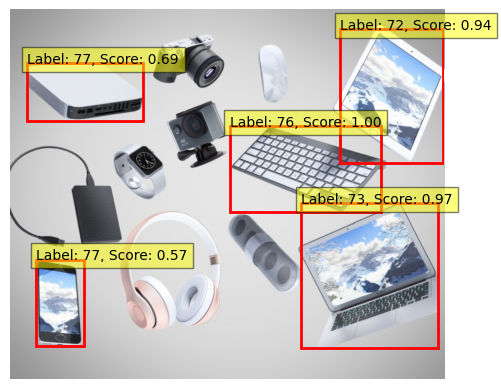

In [4]:
import requests
from PIL import Image
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# URL gambar untuk diunduh
image_url = "https://protect.cermati.com/wp-content/uploads/2023/09/barang-elektronik-768x654.jpg"  # Contoh URL gambar
output_image_path = "downloaded_image.jpg"

# Fungsi untuk mendownload gambar dari URL
def download_image(url, save_path):
    """
    Mendownload gambar dari URL yang diberikan.
    Parameter:
        url: URL gambar.
        save_path: Path untuk menyimpan gambar yang diunduh.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as image_file:
            for chunk in response.iter_content(chunk_size=1024):
                image_file.write(chunk)
        print(f"Gambar berhasil diunduh ke {save_path}")
    else:
        print(f"Gagal mengunduh gambar. Status kode: {response.status_code}")

# Mendownload gambar
download_image(image_url, output_image_path)

# Memuat model deteksi objek
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Fungsi untuk memuat gambar dan melakukan transformasi
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Membuka gambar dan mengonversinya ke RGB
    image_tensor = F.to_tensor(image)  # Mengubah gambar menjadi tensor
    return image, image_tensor.unsqueeze(0)  # Mengembalikan gambar asli dan tensor yang diubah

# Memuat gambar yang diunduh
original_image, image_tensor = load_image(output_image_path)

# Melakukan prediksi pada gambar
with torch.no_grad():
    predictions = model(image_tensor)[0]

# Menampilkan hasil deteksi
def display_detections(image, predictions, threshold=0.5):
    plt.imshow(image)
    ax = plt.gca()

    for idx, score in enumerate(predictions["scores"]):
        if score > threshold:
            bbox = predictions["boxes"][idx].tolist()
            label = predictions["labels"][idx].item()
            ax.add_patch(plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                edgecolor="red", fill=False, linewidth=2
            ))
            ax.text(bbox[0], bbox[1], f"Label: {label}, Score: {score:.2f}",
                    bbox=dict(facecolor="yellow", alpha=0.5), fontsize=10, color="black")

    plt.axis("off")
    plt.show()

# Menampilkan hasil deteksi objek
display_detections(original_image, predictions)

**Penjelasan**:
- **Model**: Menggunakan Faster R-CNN dengan backbone ResNet-50 untuk mendeteksi objek dalam gambar. ResNet-50 membantu mengekstrak fitur penting dari gambar untuk mempermudah deteksi objek.
- **Proses Deteksi**:
  1. Gambar dimuat dan diubah menjadi tensor untuk kompatibilitas dengan model.
  2. Model memprediksi bounding box (lokasi objek), skor kepercayaan, dan label objek.
  3. Hasil divisualisasikan dengan bounding box di sekitar objek yang terdeteksi, disertai skor kepercayaan.


#### **Section 2: Image Segmentation**


**Membahas apa**: Bagian ini menjelaskan segmentasi gambar, yaitu tugas untuk mengklasifikasikan setiap piksel dalam gambar ke dalam kategori tertentu.

- **Perbedaan Semantic dan Instance Segmentation**:
  - **Semantic Segmentation**: Semua piksel yang termasuk kategori yang sama akan diberi label yang sama, tanpa memperhatikan apakah mereka bagian dari objek yang berbeda. Misalnya, semua mobil di gambar akan diberi label "mobil".
  - **Instance Segmentation**: Tidak hanya mengklasifikasikan kategori piksel, tetapi juga membedakan antar objek dalam kategori yang sama. Misalnya, setiap mobil di gambar diberi label berbeda, seperti "mobil 1" dan "mobil 2".

Segmentasi gambar memiliki berbagai aplikasi, seperti:
- **Medis**: Mengidentifikasi tumor atau jaringan tertentu dalam gambar medis seperti MRI atau CT scan.
- **Kendaraan Otonom**: Memahami lingkungan dengan memetakan jalan, kendaraan, dan rambu lalu lintas.
- **Fotografi dan Seni**: Memisahkan objek dari latar belakang untuk pengeditan gambar.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 126MB/s]


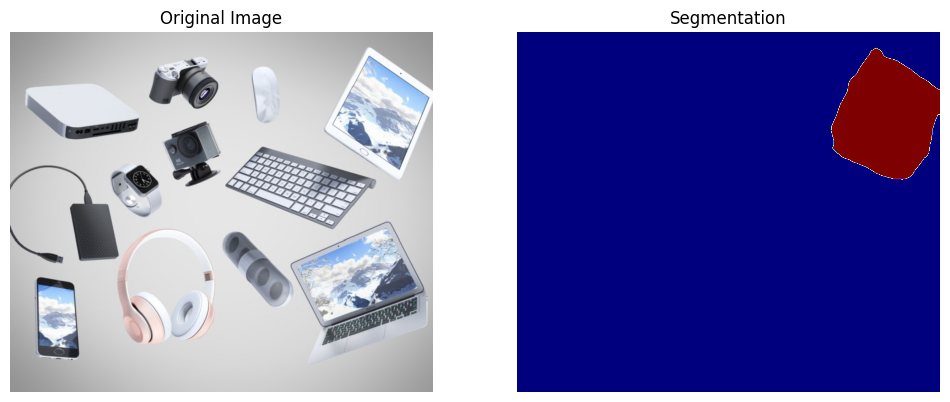

In [5]:
from torchvision.models.segmentation import deeplabv3_resnet50

# Memuat model segmentasi gambar
model = deeplabv3_resnet50(pretrained=True)
model.eval()

# Melakukan segmentasi pada gambar
with torch.no_grad():
    output = model(image_tensor)["out"][0]

# Memetakan hasil segmentasi ke format gambar
output_predictions = torch.argmax(output, dim=0).byte().cpu().numpy()

# Menampilkan hasil segmentasi
def visualize_segmentation(image_path, segmentation):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 6))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Segmentasi
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, cmap="jet")
    plt.title("Segmentation")
    plt.axis("off")

    plt.show()

# Visualisasi hasil segmentasi
visualize_segmentation(output_image_path, output_predictions)

**Penjelasan**:
- **Model**: Menggunakan DeepLabV3 dengan backbone ResNet-50 untuk melakukan segmentasi gambar. Model ini mampu mengklasifikasikan setiap piksel ke dalam kategori tertentu, seperti objek atau latar belakang.
- **Proses Segmentasi**:
  1. Gambar diproses (resize, normalisasi) agar sesuai dengan input model.
  2. Model memprediksi kategori untuk setiap piksel dalam gambar.
  3. Hasil divisualisasikan dengan peta warna untuk menunjukkan hasil segmentasi, di mana setiap warna mewakili kategori tertentu.


## **Unit 7 - Video and Video Processing**





#### **Section 1: Introduction**



**Membahas apa**: Bagian ini memberikan pengantar tentang pengolahan video dalam Computer Vision. Pengolahan video mencakup analisis aliran video secara frame-by-frame untuk mendeteksi objek bergerak, melacak objek, atau melakukan segmentasi pada frame individu. Hal ini banyak digunakan dalam aplikasi seperti pengawasan, pengenalan gerakan, dan analitik olahraga.

#### **Section 2: Video Processing Basics**


**Membahas apa**: Bagian ini menjelaskan dasar-dasar pengolahan video, seperti membaca video, memproses frame, dan menyimpan hasil pengolahan.


Video berhasil diunduh ke downloaded_video.mp4


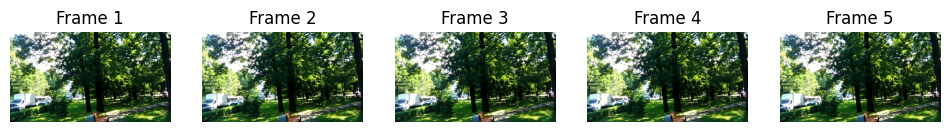

In [1]:
import cv2
import matplotlib.pyplot as plt
import requests

# URL video untuk diunduh
video_url = "https://samplelib.com/lib/preview/mp4/sample-5s.mp4"  # Contoh URL video
output_path = "downloaded_video.mp4"

# Fungsi untuk mendownload video dari URL
def download_video(url, save_path):
    """
    Mendownload video dari URL yang diberikan.
    Parameter:
        url: URL video.
        save_path: Path untuk menyimpan video yang diunduh.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as video_file:
            for chunk in response.iter_content(chunk_size=1024):
                video_file.write(chunk)
        print(f"Video berhasil diunduh ke {save_path}")
    else:
        print(f"Gagal mengunduh video. Status kode: {response.status_code}")

# Mendownload video
download_video(video_url, output_path)

# Membaca video menggunakan OpenCV
video_path = output_path  # Path video yang telah diunduh
cap = cv2.VideoCapture(video_path)  # Membuka video

# Fungsi untuk memproses dan menampilkan beberapa frame pertama
def process_video(video_capture, num_frames=5):
    """
    Fungsi ini memproses sejumlah frame pertama dari video.
    Parameter:
        video_capture: Objek VideoCapture untuk membaca video.
        num_frames: Jumlah frame yang ingin diproses.
    Return:
        frames: Daftar frame yang telah diambil dan dikonversi ke format RGB.
    """
    frames = []
    for _ in range(num_frames):
        ret, frame = video_capture.read()  # Membaca frame dari video
        if not ret:  # Jika tidak ada frame yang terbaca (end of video), keluar dari loop
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Mengonversi frame ke format RGB
        frames.append(frame_rgb)  # Menambahkan frame yang telah dikonversi ke daftar

    video_capture.release()  # Menutup video setelah selesai diproses
    return frames

# Mendapatkan frame dari video
frames = process_video(cap, num_frames=5)

# Menampilkan frame pertama untuk visualisasi
plt.figure(figsize=(12, 6))
for idx, frame in enumerate(frames):
    plt.subplot(1, len(frames), idx + 1)  # Membuat subplot untuk setiap frame
    plt.imshow(frame)  # Menampilkan frame dalam format RGB
    plt.title(f"Frame {idx + 1}")  # Memberikan judul untuk setiap frame
    plt.axis("off")  # Menghilangkan axis untuk visualisasi yang lebih bersih
plt.show()

**Penjelasan Lengkap**:
- **Download Video**: Video diunduh dari URL menggunakan pustaka `requests` dan disimpan ke path lokal.
- **OpenCV**: OpenCV adalah pustaka yang kuat untuk pemrosesan gambar dan video. Dalam kode ini, `cv2.VideoCapture` digunakan untuk membuka dan membaca video secara frame-by-frame.
- **Proses Pembacaan Video**:
  1. **Membuka Video**: Video dibuka menggunakan `cv2.VideoCapture`. Pastikan path video benar.
  2. **Membaca Frame**: Setiap frame diambil menggunakan `read()`, yang mengembalikan dua nilai: `ret` (boolean untuk menunjukkan keberhasilan membaca) dan `frame` (data frame itu sendiri).
  3. **Konversi Warna**: Frame yang dibaca dikonversi dari format BGR (default OpenCV) ke RGB agar kompatibel dengan Matplotlib.
  4. **Penyimpanan Frame**: Frame yang telah dikonversi disimpan dalam daftar `frames`.
- **Penutupan Video**:
  - Setelah semua frame yang diinginkan diproses, video ditutup menggunakan `release()` untuk membebaskan sumber daya sistem.
- **Visualisasi**:
  - Frame yang telah diproses divisualisasikan menggunakan Matplotlib. `plt.subplot` digunakan untuk menampilkan beberapa frame secara berdampingan.
- **Penggunaan Nyata**:
  - Dasar-dasar ini dapat diperluas untuk melakukan analisis video lebih lanjut seperti pelacakan objek, deteksi gerakan, atau segmentasi video.


## **Unit 8 - 3D Vision, Scene Rendering, and Reconstruction**






#### **Section 1: Introduction**


**Membahas apa**: Unit ini memperkenalkan konsep Computer Vision dalam domain 3D, termasuk rendering adegan, rekonstruksi 3D, dan analisis struktur adegan. Fokusnya adalah pada teknik-teknik untuk memahami dunia 3D dari data 2D.

#### **Section 2: Applications of 3D Vision**


**Membahas apa**: Bagian ini menguraikan aplikasi utama visi 3D, seperti:
- **Autonomous Vehicles**: Navigasi menggunakan peta 3D dan deteksi objek.
- **Medis**: Pemindaian 3D untuk diagnosa dan perencanaan operasi.
- **Augmented Reality (AR) dan Virtual Reality (VR)**: Pengalaman imersif berbasis data spasial.
- **Gaming**: Pembuatan peta 3D untuk lingkungan game, memungkinkan pengalaman bermain yang lebih realistis.
- **Drone Mapping**: Pemetaan infrastruktur seperti jembatan, gedung, dan area pertanian menggunakan drone untuk menghasilkan representasi 3D akurat.
- **Cultural Heritage Preservation**: Dokumentasi dan rekonstruksi digital situs bersejarah dalam bentuk model 3D untuk keperluan pelestarian dan pendidikan.


#### **Section 3: A Brief History of 3D Vision**


**Membahas apa**: Bagian ini mencakup perkembangan historis dari visi komputer 3D, mulai dari stereoskopi hingga teknologi modern seperti LIDAR dan NeRFs (Neural Radiance Fields).

**Tonggak Sejarah Utama**:
- **1838 - Penemuan Stereoskop**: Charles Wheatstone memperkenalkan perangkat yang menggunakan dua gambar untuk menciptakan ilusi kedalaman.
- **1980-an - Epipolar Geometry**: Konsep ini membantu mendefinisikan hubungan geometris antara dua gambar untuk rekonstruksi 3D.
- **1990-an - Pengenalan LIDAR**: Teknologi ini memungkinkan pemetaan 3D presisi tinggi menggunakan laser.
- **2019 - Neural Radiance Fields (NeRF)**: Memanfaatkan neural networks untuk mempelajari representasi pemandangan 3D dari kumpulan gambar 2D.


#### **Section 4: Camera Models**


**Membahas apa**: Model kamera digunakan untuk memahami bagaimana kamera menangkap gambar dari dunia nyata.


In [7]:
import numpy as np

# Matriks intrinsik kamera (contoh sederhana)
def intrinsic_matrix(focal_length, cx, cy):
    """
    Menghitung matriks intrinsik kamera.
    Parameter:
        focal_length: Panjang fokus kamera.
        cx, cy: Titik tengah optik di koordinat gambar.
    Return:
        Matriks intrinsik 3x3.
    """
    return np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ])

# Contoh penggunaan
focal_length = 800
cx, cy = 320, 240
K = intrinsic_matrix(focal_length, cx, cy)
print("Matriks intrinsik:")
print(K)

Matriks intrinsik:
[[800   0 320]
 [  0 800 240]
 [  0   0   1]]


Penjelasan elemen-elemen dalam matriks ini:
1. **Elemen (0,0) dan (1,1):** Menunjukkan panjang fokus kamera dalam satuan piksel, yaitu 800.
2. **Elemen (0,2) dan (1,2):** Menunjukkan koordinat titik pusat optik (principal point) pada gambar, yaitu (320, 240).
3. **Elemen (2,2):** Selalu bernilai 1 dalam matriks intrinsik untuk mempertahankan homogenitas koordinat.


**Penjelasan**:
- **Matriks Intrinsik**: Memodelkan parameter internal kamera seperti panjang fokus dan posisi titik tengah optik.
- **Penerapan**: Digunakan dalam kalibrasi kamera dan rekonstruksi adegan 3D.

**Contoh Penerapan di Dunia Nyata**:
Dalam fotografi arsitektur, parameter intrinsik kamera sangat penting untuk memastikan gambar tidak mengalami distorsi perspektif. Sebagai contoh, panjang fokus kamera digunakan untuk menghitung sudut pandang sehingga gambar gedung yang tinggi tetap terlihat lurus dan tidak melengkung. Titik tengah optik juga membantu dalam menjaga simetri saat memotret langsung ke pusat objek, seperti fasad bangunan.


#### **Section 5: Basics of Linear Algebra for 3D Data**



**Membahas apa**: Bagian ini membahas konsep aljabar linier dasar seperti transformasi matriks, rotasi, dan translasi yang digunakan untuk memanipulasi data 3D.

In [14]:
import numpy as np

# Matriks rotasi (contoh rotasi di sekitar sumbu-z)
def rotation_matrix_z(angle):
    """
    Menghasilkan matriks rotasi 3x3 di sekitar sumbu-z.
    Parameter:
        angle: Sudut rotasi dalam derajat.
    Return:
        Matriks rotasi 3x3.
    """
    rad = np.radians(angle)
    return np.array([
        [np.cos(rad), -np.sin(rad), 0],
        [np.sin(rad), np.cos(rad), 0],
        [0, 0, 1]
    ])

# Matriks translasi
def translation_matrix(tx, ty, tz):
    """
    Menghasilkan matriks translasi 4x4.
    Parameter:
        tx, ty, tz: Translasi pada sumbu x, y, z.
    Return:
        Matriks translasi 4x4.
    """
    return np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ])

# Contoh rotasi dan translasi simultan pada dataset 3D
def transform_3d_dataset(points, angle, tx, ty, tz):
    """
    Menerapkan rotasi dan translasi pada dataset 3D.
    Parameter:
        points: Array (N, 3) berisi koordinat 3D.
        angle: Sudut rotasi di sekitar sumbu-z (dalam derajat).
        tx, ty, tz: Translasi pada sumbu x, y, z.
    Return:
        Dataset 3D yang ditransformasi.
    """
    # Menambahkan kolom homogen ke dataset
    points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

    # Matriks rotasi dan translasi
    Rz = np.eye(4)
    Rz[:3, :3] = rotation_matrix_z(angle)
    T = translation_matrix(tx, ty, tz)

    # Menggabungkan rotasi dan translasi
    transform = T @ Rz

    # Menerapkan transformasi
    transformed_points = (transform @ points_homogeneous.T).T[:, :3]
    return transformed_points

# Dataset 3D awal (10 titik acak)
points = np.random.rand(10, 3) * 10

# Menerapkan rotasi 45 derajat dan translasi (5, -3, 2)
transformed_points = transform_3d_dataset(points, angle=45, tx=5, ty=-3, tz=2)

print("Titik awal:")
print(points)
print("Titik setelah transformasi:")
print(transformed_points)

Titik awal:
[[2.46899647 1.54863673 8.5187627 ]
 [0.96757353 5.81324597 5.52619027]
 [5.42089002 5.67147892 4.06906418]
 [6.33596236 3.98720837 2.65575191]
 [1.77313065 7.78835405 8.8706609 ]
 [9.29492018 2.27254294 8.33926499]
 [2.55829549 5.89898274 3.62403248]
 [0.39463532 3.0476698  5.47221314]
 [8.63126571 0.31213801 4.57908511]
 [9.62692781 5.45679992 3.15249609]]
Titik setelah transformasi:
[[ 5.65079261 -0.15910431 10.5187627 ]
 [ 1.57359215  1.79476345  7.52619027]
 [ 4.82280689  4.84348929  6.06906418]
 [ 6.66081987  4.29958403  4.65575191]
 [ 0.74659474  3.76099067 10.8706609 ]
 [ 9.96557056  5.17943161 10.33926499]
 [ 2.63777739  2.98019879  5.62403248]
 [ 3.12402133 -0.56592271  7.47221314]
 [10.88251161  3.32394142  6.57908511]
 [ 7.9487257   7.66580617  5.15249609]]




 **Penjelasan Transformasi:**
- **Rotasi 45° di sumbu-Z:** Koordinat \(x\) dan \(y\) berubah sesuai sudut rotasi. Koordinat \(z\) tetap tidak berubah karena rotasi hanya di sekitar sumbu-Z.
- **Translasi:** Setiap titik digeser sebesar \(tx = 5\), \(ty = -3\), dan \(tz = 2\).



**Penjelasan**:
- **Rotasi dan Translasi**: Digunakan untuk memutar dan menggeser dataset 3D secara simultan.
- **Dataset 3D**: Setiap titik dalam dataset direpresentasikan sebagai koordinat (x, y, z).
- **Homogeneous Coordinates**: Digunakan untuk menggabungkan rotasi dan translasi dalam satu matriks transformasi.


#### **Section 6: Representations for 3D Data**



**Membahas apa**: Menjelaskan representasi data 3D seperti:

1. **Point Clouds**:
   - **Definisi**: Kumpulan titik di ruang 3D yang merepresentasikan permukaan objek atau lingkungan.
   - **Kapan Digunakan**: Cocok untuk aplikasi seperti LIDAR, pemindaian 3D, dan rekonstruksi bentuk objek sederhana.
   - **Kelebihan**: Kompak dan mudah diproses.
   - **Kekurangan**: Tidak menyimpan informasi topologi (hubungan antara titik).

2. **Voxel Grids**:
   - **Definisi**: Representasi volumetrik di mana ruang 3D dibagi menjadi unit kecil berbentuk kubus (voxel).
   - **Kapan Digunakan**: Berguna untuk aplikasi yang memerlukan analisis volume, seperti simulasi medis atau pengindeksan ruang 3D.
   - **Kelebihan**: Menyimpan informasi volumetrik secara eksplisit.
   - **Kekurangan**: Konsumsi memori tinggi untuk resolusi tinggi.

3. **Meshes**:
   - **Definisi**: Representasi menggunakan simpul (vertices), sisi (edges), dan wajah (faces) untuk merepresentasikan bentuk objek.
   - **Kapan Digunakan**: Digunakan dalam game, grafik komputer, dan CAD (Computer-Aided Design).
   - **Kelebihan**: Menyimpan informasi topologi dengan baik dan memungkinkan rendering realistis.
   - **Kekurangan**: Kompleks untuk diproses dibandingkan Point Clouds.

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np

# Data point cloud
points = np.random.rand(100, 3)
df = pd.DataFrame(points, columns=['x', 'y', 'z'])

# Plot 3D
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()


**Penjelasan**:
- **Point Cloud**: Digunakan untuk merepresentasikan bentuk permukaan objek dalam ruang 3D.
- **Voxel Grids**: Representasi volumetrik untuk simulasi atau analisis berbasis ruang.
- **Meshes**: Sangat cocok untuk aplikasi yang memerlukan detail geometris dan topologi objek.


#### **Section 7: Novel View Synthesis**


**Membahas apa**: Teknik untuk menghasilkan pandangan baru dari data 3D menggunakan interpolasi atau model pembelajaran mesin.


**Teknik Interpolasi**:
1. **Linear Interpolation (Lerp)**:
   - Teknik ini menghitung nilai antara dua titik dengan memberikan bobot tertentu.
   - Contoh: Jika ada dua posisi kamera, interpolasi linear dapat digunakan untuk menghasilkan posisi kamera di antara dua titik tersebut.


In [5]:
import numpy as np

# Contoh interpolasi linear
def linear_interpolation(p1, p2, t):
    """
    Menghitung interpolasi linear antara dua titik.
    Parameter:
        p1, p2: Titik awal dan akhir (array numpy).
        t: Faktor interpolasi (0 hingga 1).
    Return:
        Titik interpolasi.
    """
    return (1 - t) * p1 + t * p2

# Titik kamera awal dan akhir
camera_pos1 = np.array([0, 0, 0])
camera_pos2 = np.array([10, 10, 10])

# Interpolasi pada t = 0.5 (tengah-tengah)
interpolated_pos = linear_interpolation(camera_pos1, camera_pos2, t=0.5)
print("Posisi interpolasi:", interpolated_pos)

Posisi interpolasi: [5. 5. 5.]


2. **Spherical Linear Interpolation (Slerp)**:
   - Digunakan untuk interpolasi rotasi di ruang 3D.
   - Cocok untuk menghasilkan pandangan kamera yang halus dalam lintasan melingkar.

**Penjelasan**:
- **Linear Interpolation**: Menghasilkan transisi linier antara dua posisi kamera.
- **Spherical Linear Interpolation**: Berguna untuk menghasilkan transisi rotasi halus antara dua orientasi kamera.


#### **Section 8: Introduction to Stereo Vision**



**Membahas apa**: Stereo vision menggunakan dua gambar dari sudut pandang berbeda untuk memperkirakan kedalaman dalam adegan.

**Contoh dalam Robotika**:
Stereo vision sering digunakan dalam robotika untuk navigasi dan pengukuran jarak. Misalnya, robot dapat menggunakan dua kamera yang dipasang sejajar untuk mengukur kedalaman objek di depannya. Data kedalaman ini memungkinkan robot untuk menghindari rintangan atau memanipulasi objek dengan tepat.

In [12]:
# Contoh sederhana triangulasi stereo
baseline = 0.1  # Jarak antara dua kamera (meter)
focal_length = 800  # Panjang fokus (piksel)
disparity = 32  # Perbedaan piksel antara dua gambar

# Menghitung kedalaman
depth = (baseline * focal_length) / disparity
print(f"Kedalaman objek: {depth} meter")

Kedalaman objek: 2.5 meter


**Penjelasan**:
- **Disparity**: Perbedaan posisi objek dalam dua gambar stereo.
- **Kedalaman**: Dihitung menggunakan triangulasi geometri sederhana.
- **Aplikasi Robotika**: Robot dapat menggunakan informasi ini untuk menentukan jarak ke objek dan merencanakan gerakan.


#### **Section 9: Neural Radiance Fields (NeRFs)**



**Membahas apa**: NeRF adalah teknik berbasis neural untuk mempelajari representasi pemandangan 3D dari gambar 2D.

In [16]:
import torch
import torch.nn as nn

# Definisi Model NeRF
class NeRFModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, output_dim=4):
        super(NeRFModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Contoh Input: Koordinat 3D (x, y, z)
coordinates = torch.rand(10, 3)  # 10 titik acak di ruang 3D

# Inisialisasi Model NeRF
nerf_model = NeRFModel()

# Output: Warna dan Densitas untuk setiap titik
output = nerf_model(coordinates)
print("Output NeRF (Warna dan Densitas):")
print(output)

Output NeRF (Warna dan Densitas):
tensor([[-4.4826e-02,  7.6585e-04,  1.3090e-01,  1.5706e-02],
        [-6.7022e-02, -7.3093e-03,  1.4085e-01, -2.2352e-02],
        [-4.5582e-02,  1.1775e-02,  1.3893e-01,  1.0915e-02],
        [-2.8528e-02,  1.0363e-03,  1.4564e-01,  1.5998e-02],
        [-6.0466e-02,  5.5331e-03,  1.4100e-01, -1.2526e-02],
        [-4.0747e-02, -4.5572e-03,  1.5054e-01, -6.7193e-03],
        [-1.3090e-02, -1.0482e-02,  1.2220e-01,  1.4487e-02],
        [-7.4103e-02,  6.0141e-04,  1.3832e-01, -2.1027e-03],
        [-4.6866e-02,  2.1713e-02,  1.6053e-01, -5.8289e-03],
        [-5.6307e-02, -9.3751e-05,  1.3689e-01, -1.8583e-03]],
       grad_fn=<AddmmBackward0>)


Output tensor tersebut adalah hasil dari model NeRF yang merepresentasikan **warna (RGB)** dan **densitas** untuk 10 titik di ruang 3D.

- **Kolom 1–3:** Warna (komponen R, G, B) setiap titik.
- **Kolom 4:** Densitas (mengukur kepadatan titik, menentukan opasitas/transparansi).


**Penjelasan**:
- **Input**: Koordinat 3D dari ruang adegan.
- **Output**: Vektor yang merepresentasikan warna (RGB) dan densitas (alpha) dari setiap titik dalam adegan.
- **Aplikasi**: Digunakan untuk rendering realistis dan rekonstruksi pemandangan 3D dengan memanfaatkan koordinat spasial dan arah pandangan.
